### Import Libraries


In [1]:
import pandas as pd
import pathlib
from joblib import load
from matplotlib import pyplot as plt
import itertools

import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import class_PR_curves, class_PR_curves_SCM


### Load models and datasets


In [2]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)

### Evaluate each model on each dataset (multiclass)


Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: train


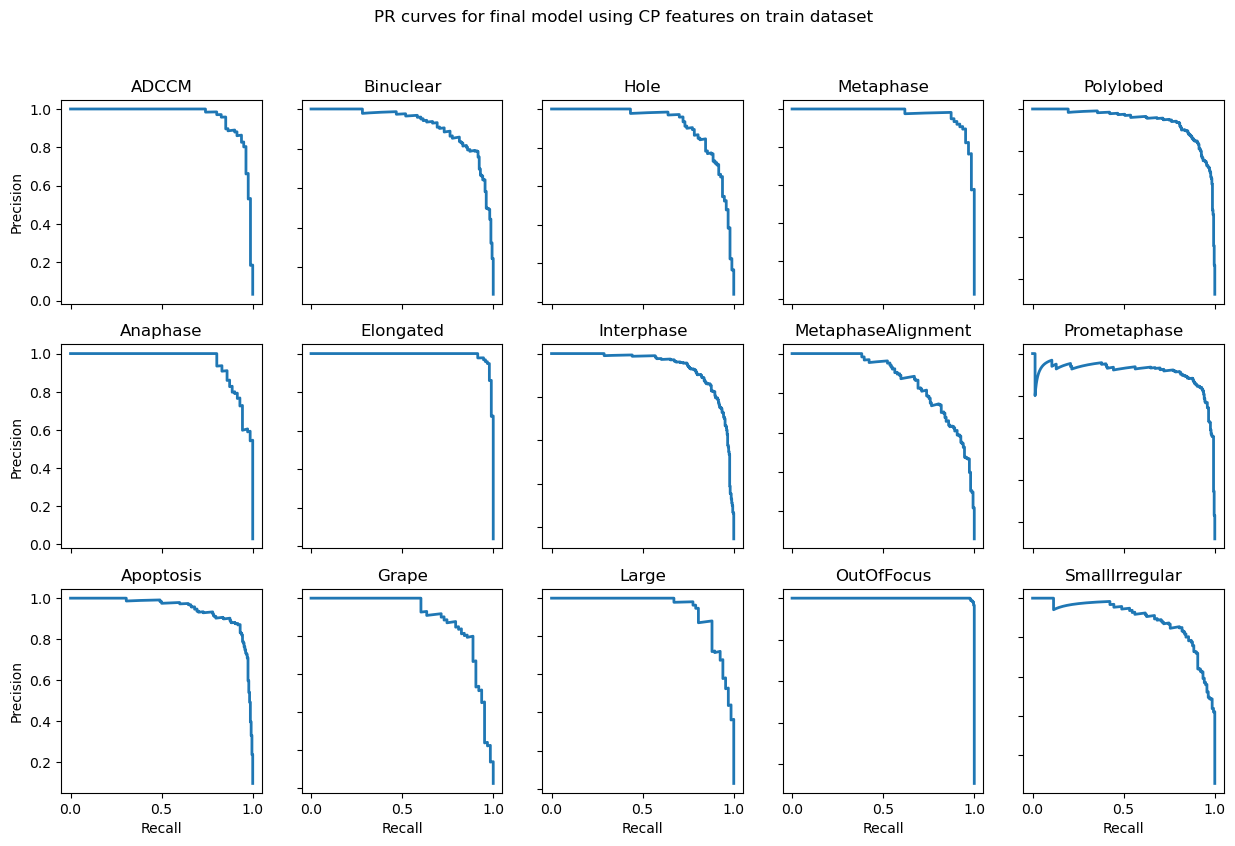

Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: test


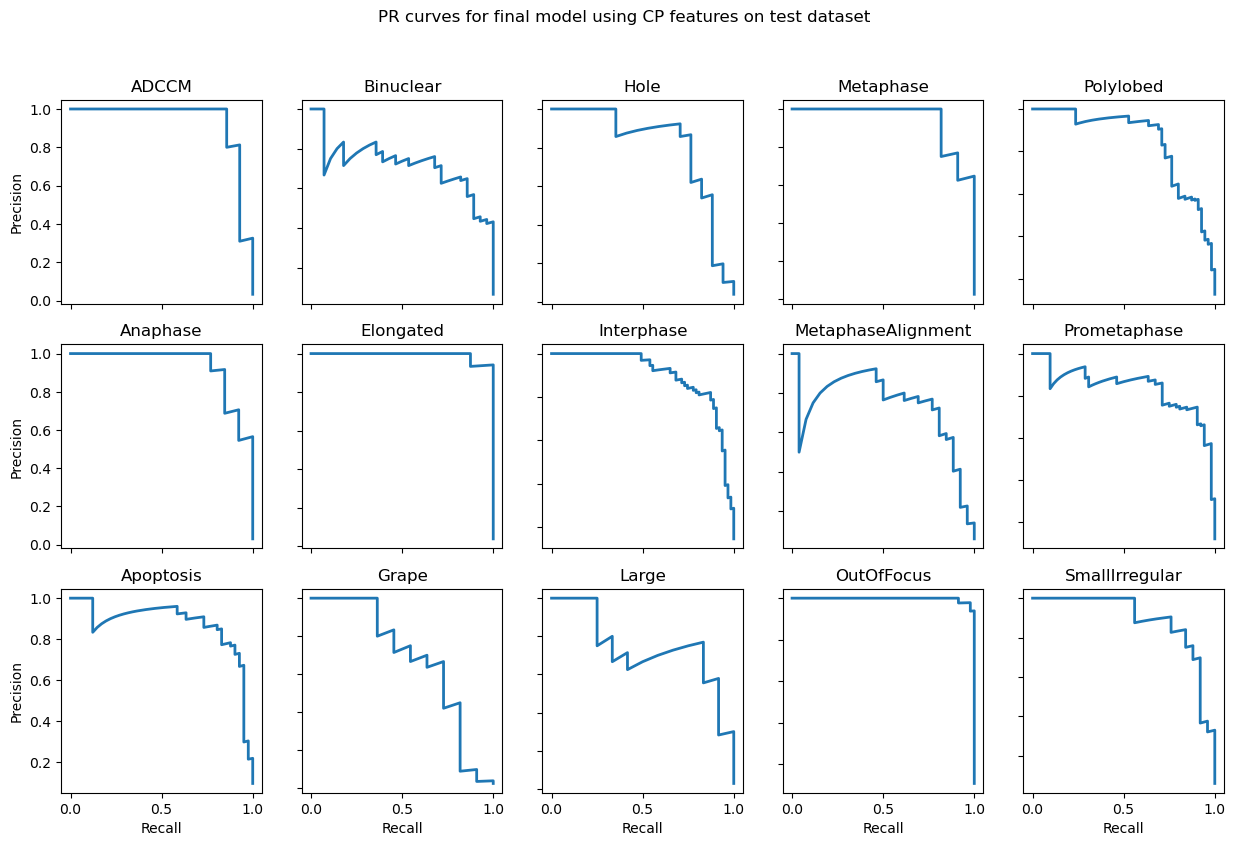

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: train


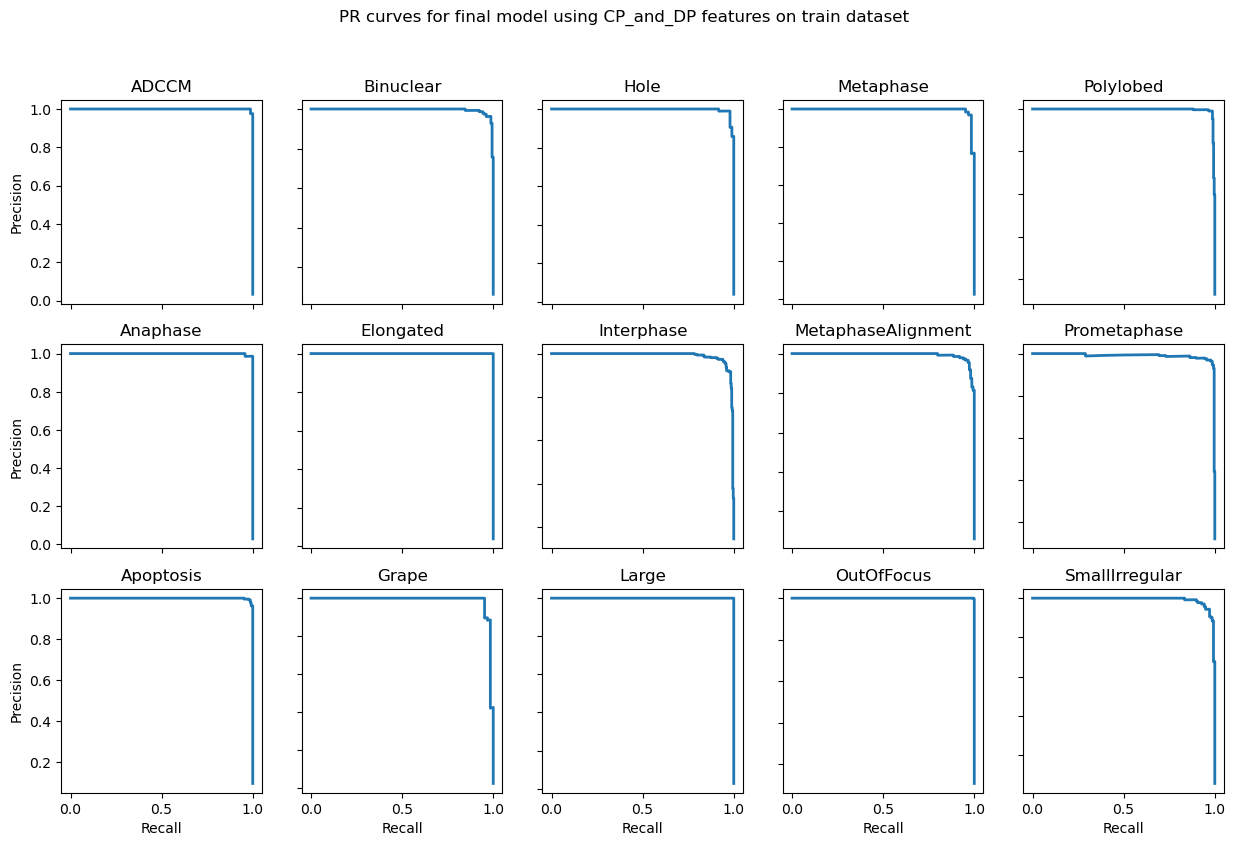

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: test


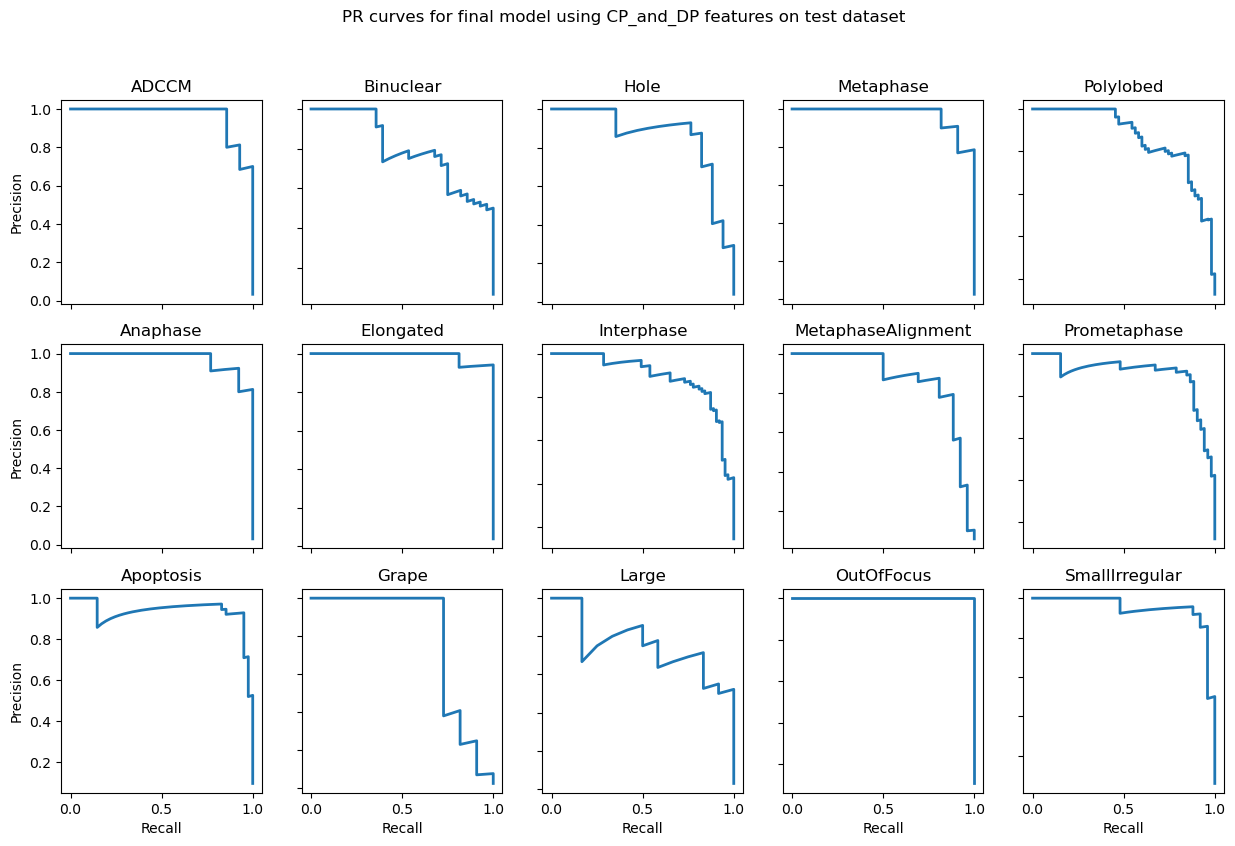

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: train


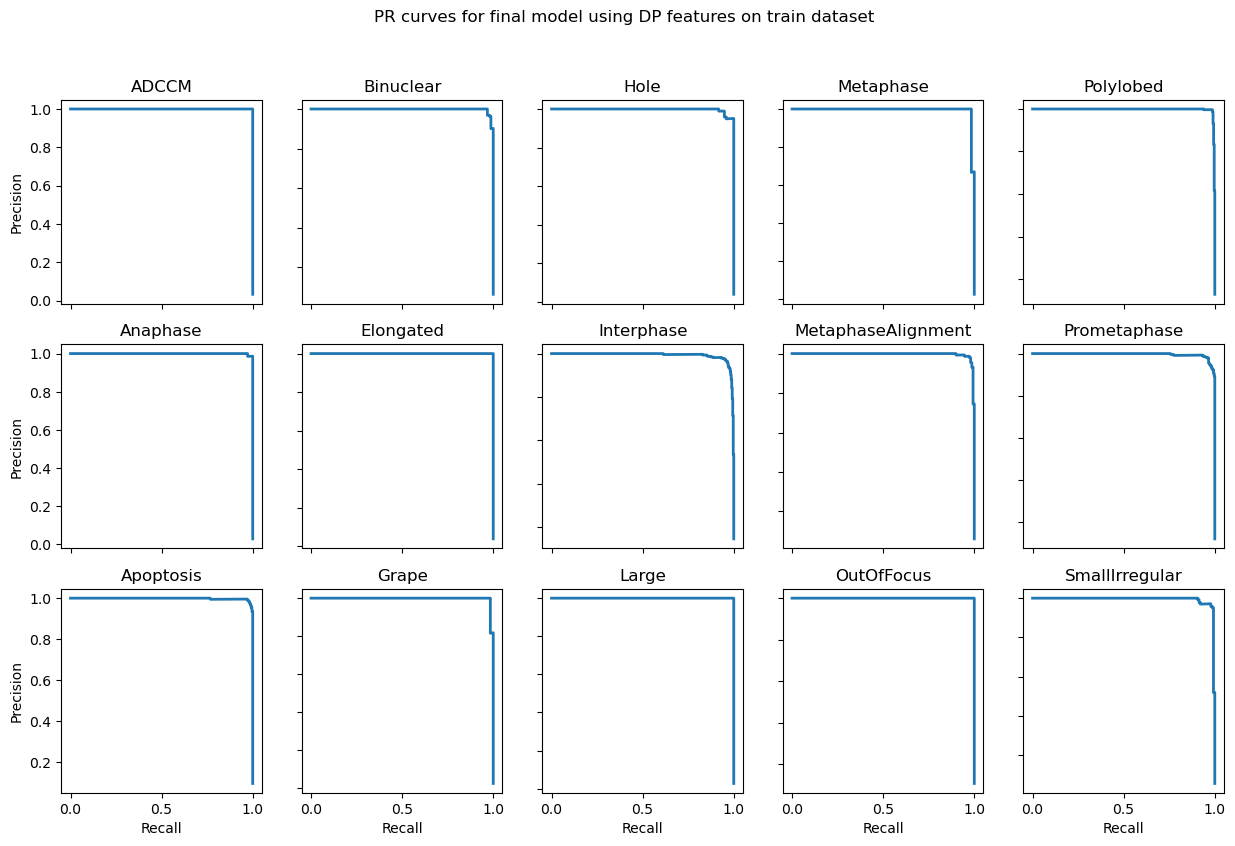

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: test


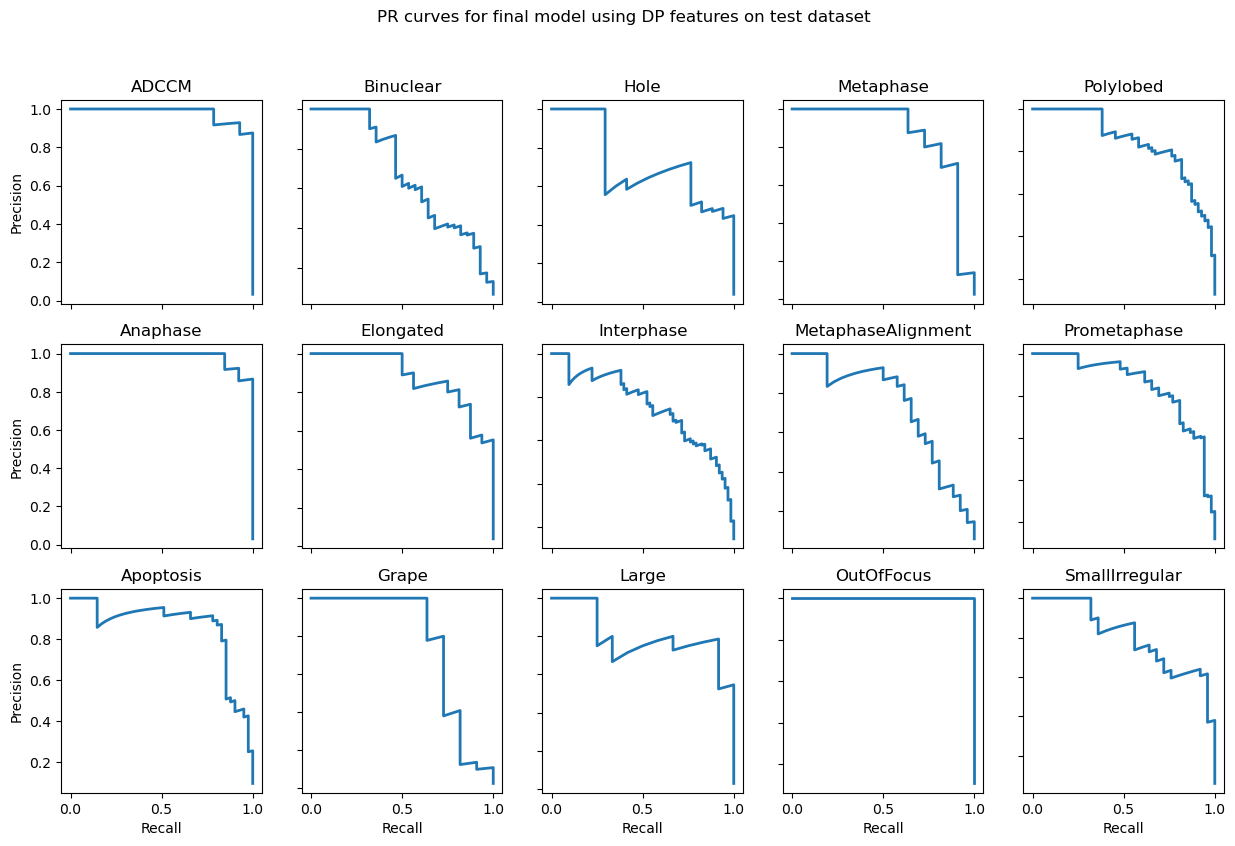

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: train


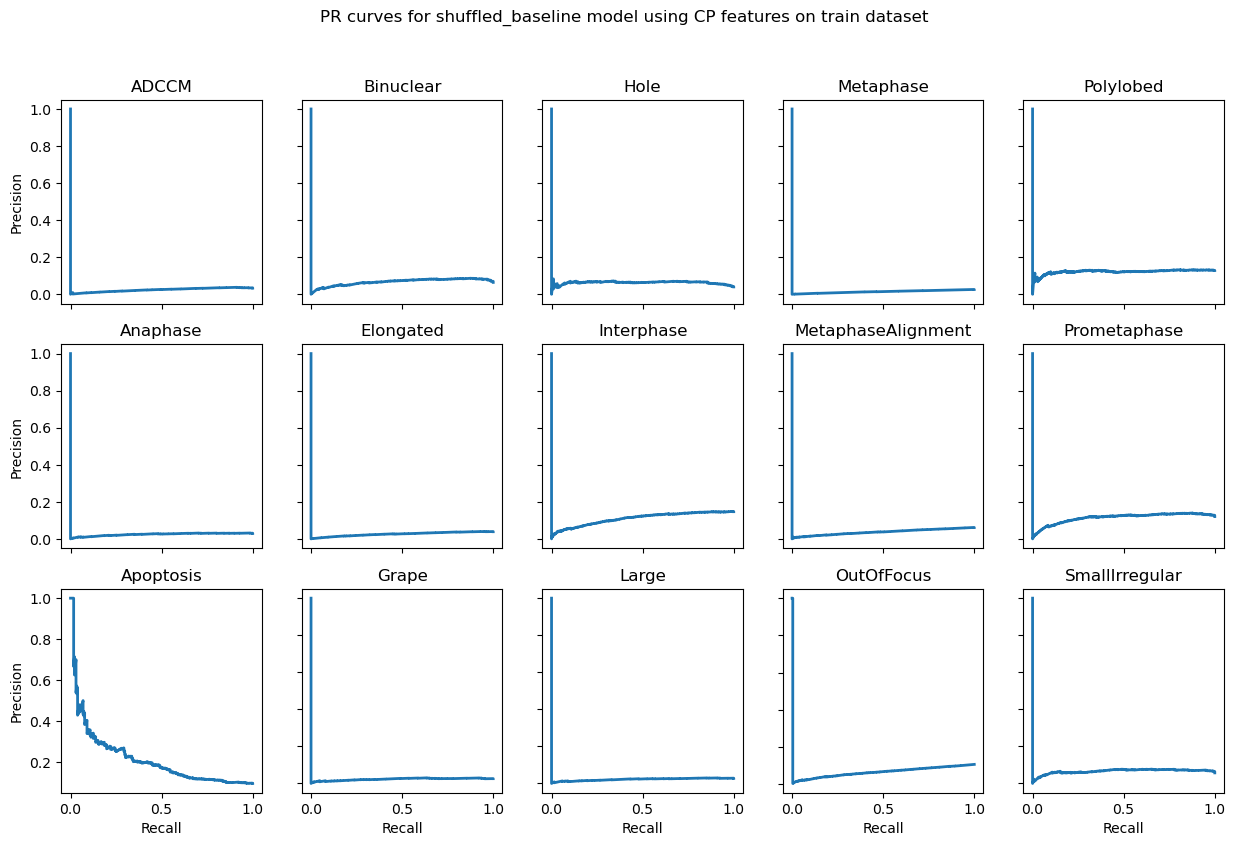

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: test


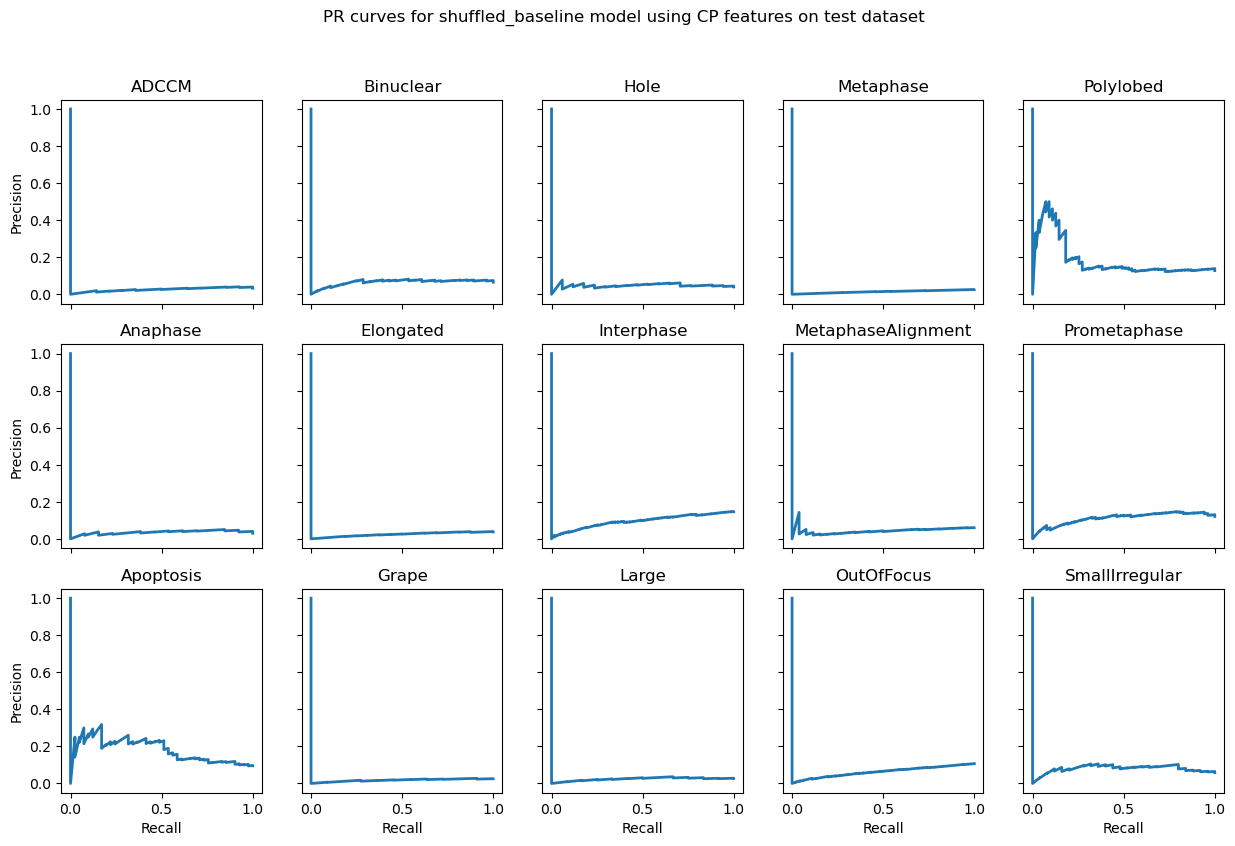

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: train


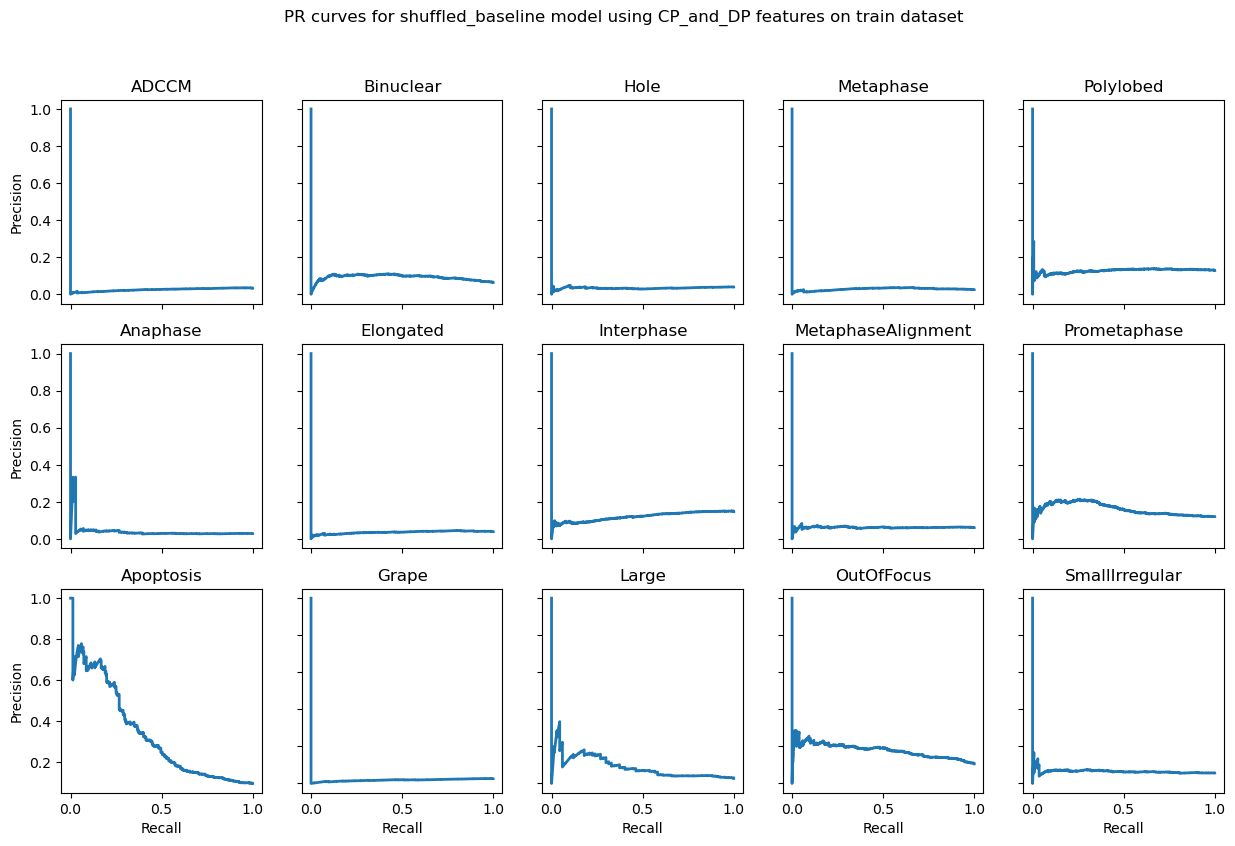

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: test


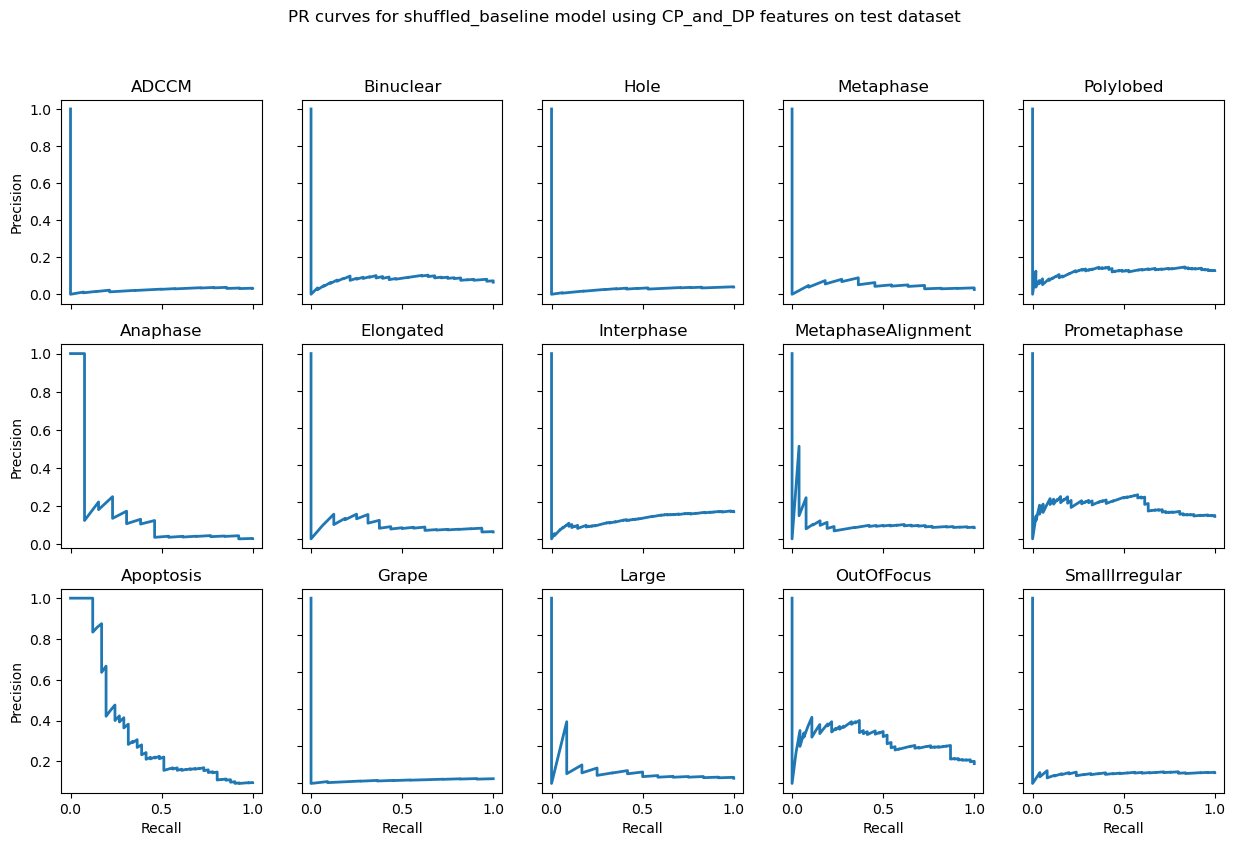

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: train


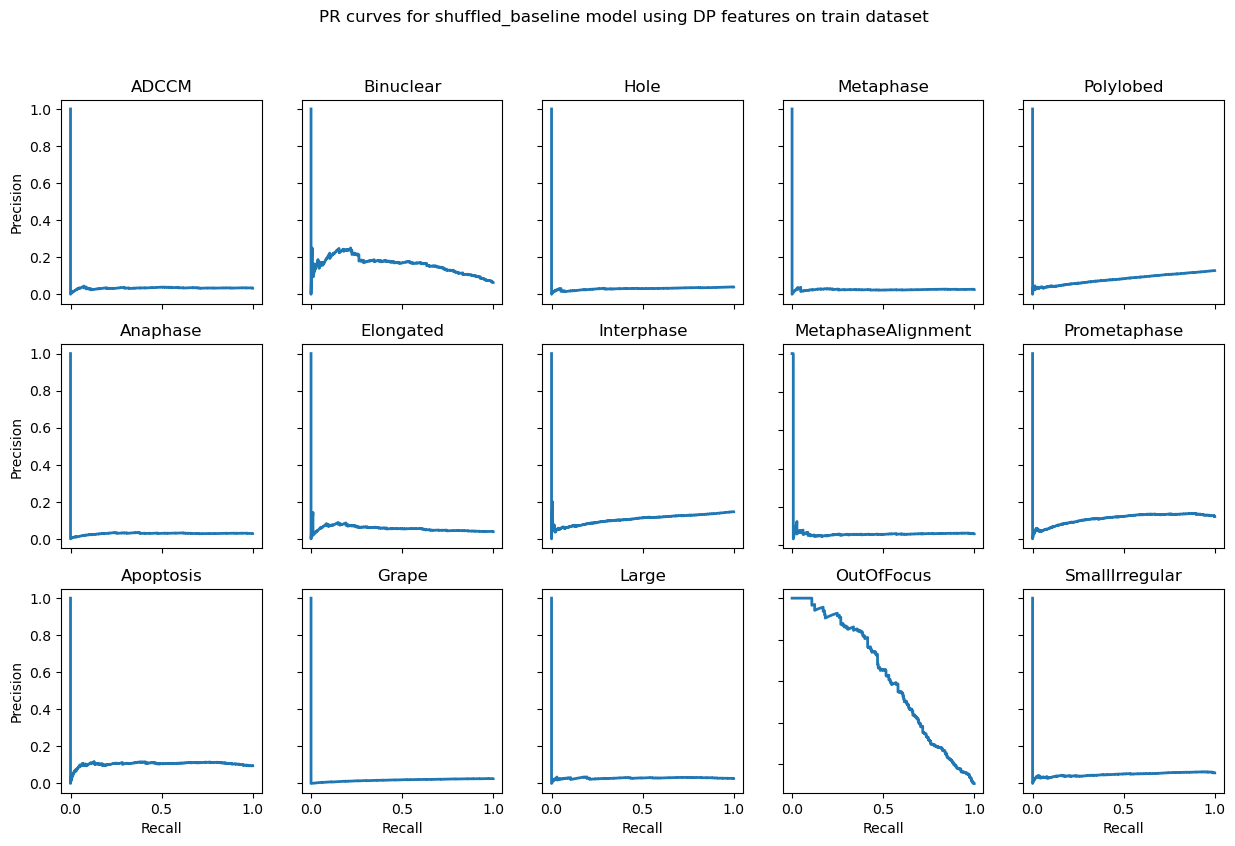

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: test


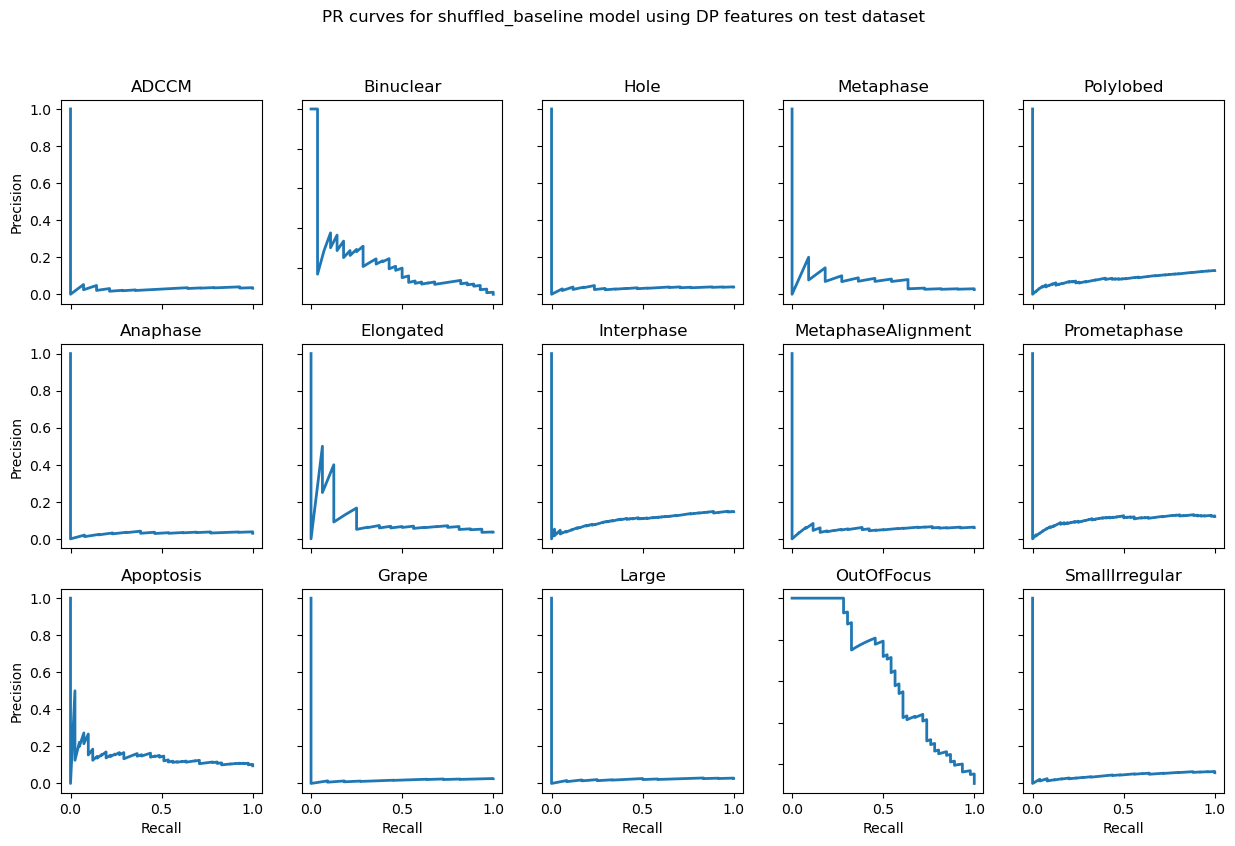

In [3]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/multi_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_class_PR_curves = []

# iterate through each model (final model, shuffled baseline model, etc)
# sorted so final models are shown before shuffled_baseline
for model_path in sorted(models_dir.iterdir()):
    # load model
    model = load(model_path)
    # determine model/feature type from model file name
    model_type = model_path.name.split("__")[0]
    feature_type = model_path.name.split("__")[1].replace(".joblib", "")

    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(
            f"Evaluating model: {model_type} \nTrained with features: {feature_type} \nEvaluating with dataset: {label}"
        )

        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)

        # get class PR curve data and show curve
        fig, PR_data = class_PR_curves(data, model, feature_type)
        fig.suptitle(
            f"PR curves for {model_type} model using {feature_type} features on {label} dataset"
        )
        plt.show()

        # add data split column to indicate which dataset scores are from (train, test, etc)
        PR_data["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        PR_data["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        PR_data["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_class_PR_curves.append(PR_data)

### Save PR curves from each evaluation (multiclass)


In [4]:
# compile list of tidy data into one dataframe
# some thresholds are None because last PR value doesn't correspond to cell dataset (these values are always P=1, R=0), remove these rows from PR data
compiled_class_PR_curves = (
    pd.concat(compiled_class_PR_curves).dropna().reset_index(drop=True)
)

# specify results directory
PR_curves_dir = pathlib.Path("evaluations/precision_recall_curves/")
PR_curves_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_PR_data_save_path = pathlib.Path(
    f"{PR_curves_dir}/compiled_class_PR_curves.tsv"
)

# save data as tsv
compiled_class_PR_curves.to_csv(compiled_PR_data_save_path, sep="\t")

# preview tidy data
compiled_class_PR_curves

,Phenotypic_Class,PR_Threshold,Precision,Recall,data_split,shuffled,feature_type
0,ADCCM,0.0,0.033306,1.0,train,False,CP
1,ADCCM,0.0,0.033320,1.0,train,False,CP
2,ADCCM,0.0,0.033333,1.0,train,False,CP
3,ADCCM,0.0,0.033347,1.0,train,False,CP
4,ADCCM,0.0,0.033361,1.0,train,False,CP
...,...,...,...,...,...,...,...
257575,SmallIrregular,0.122979,0.000000,0.0,test,True,DP
257576,SmallIrregular,0.124633,0.000000,0.0,test,True,DP
257577,SmallIrregular,0.128889,0.000000,0.0,test,True,DP
257578,SmallIrregular,0.130976,0.000000,0.0,test,True,DP


### Evaluate each model on each dataset (multiclass)


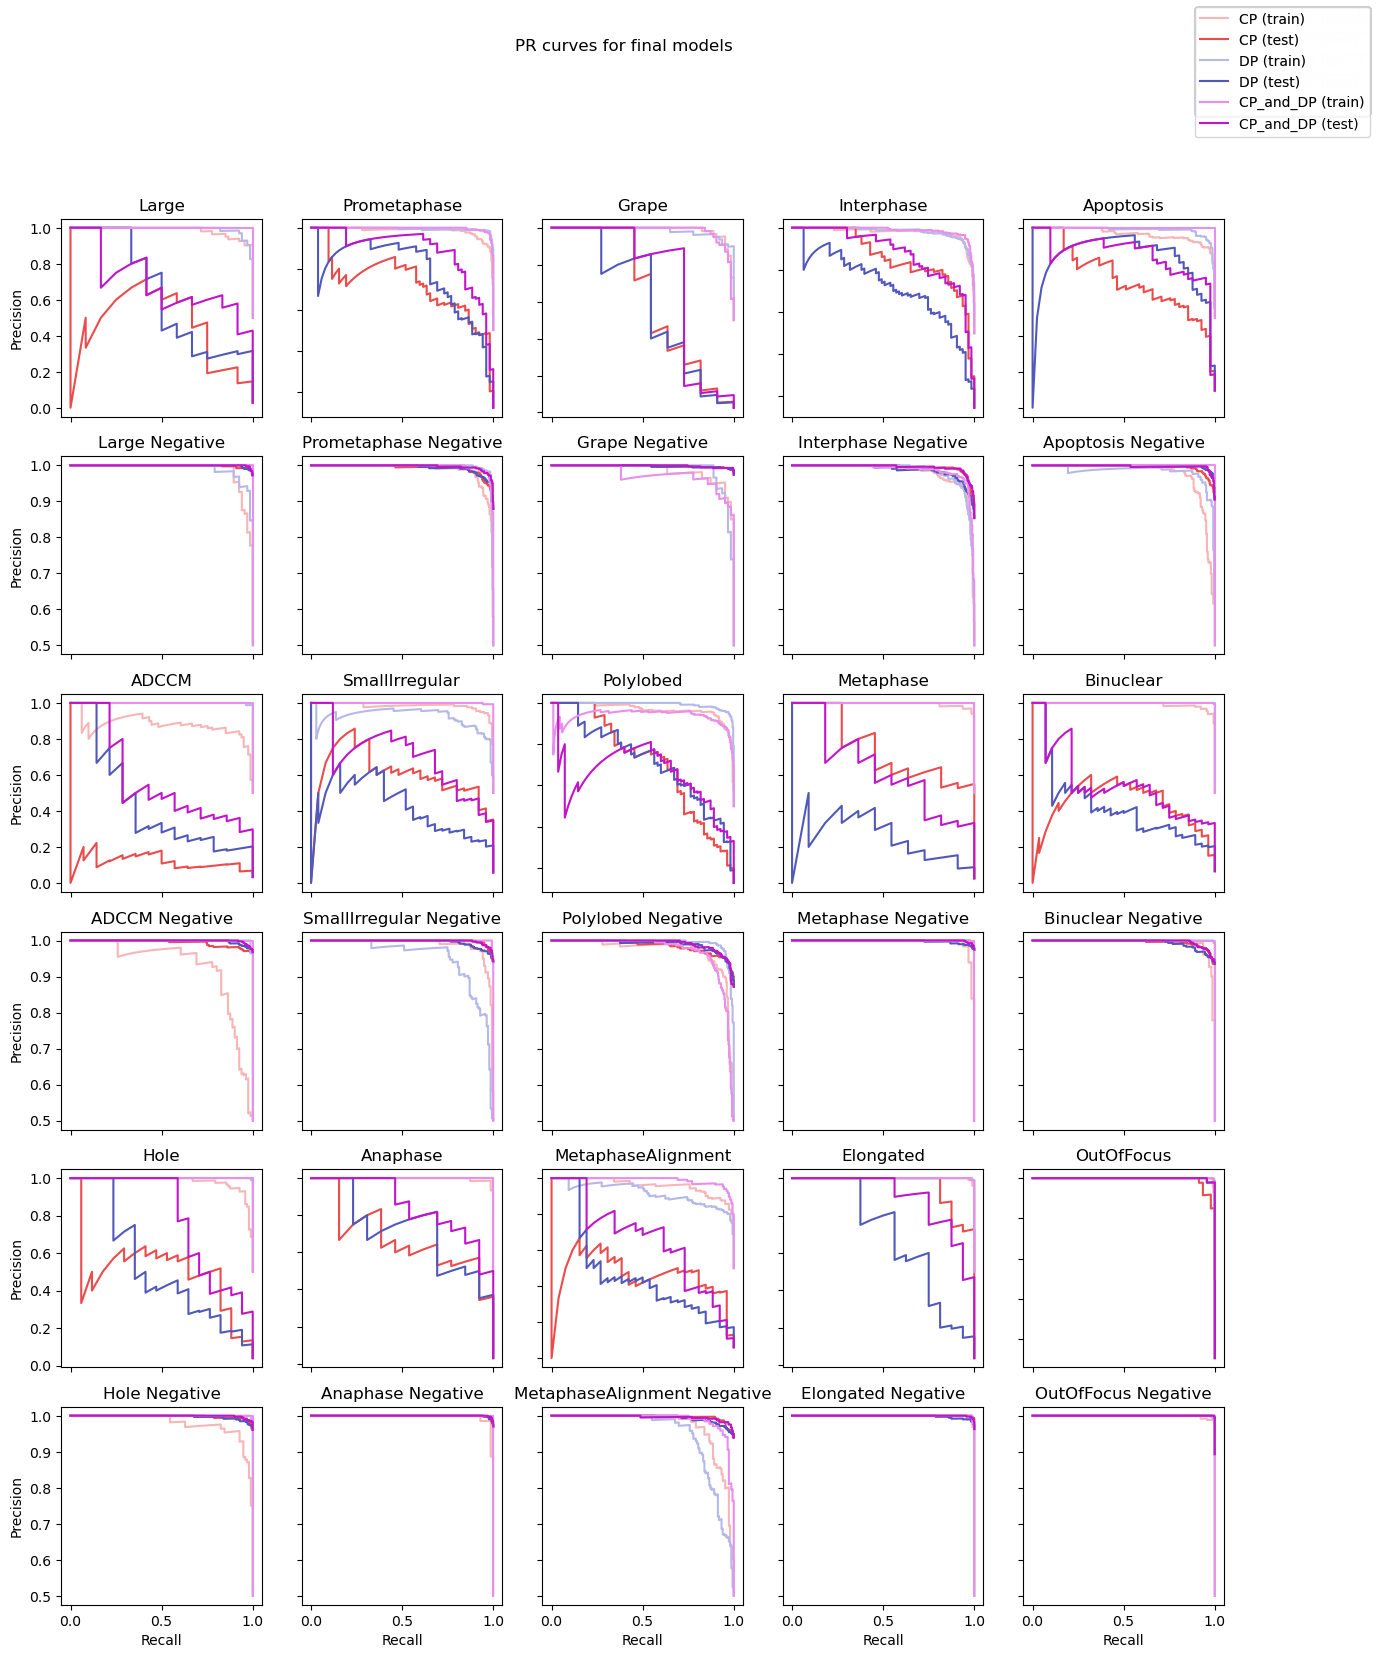

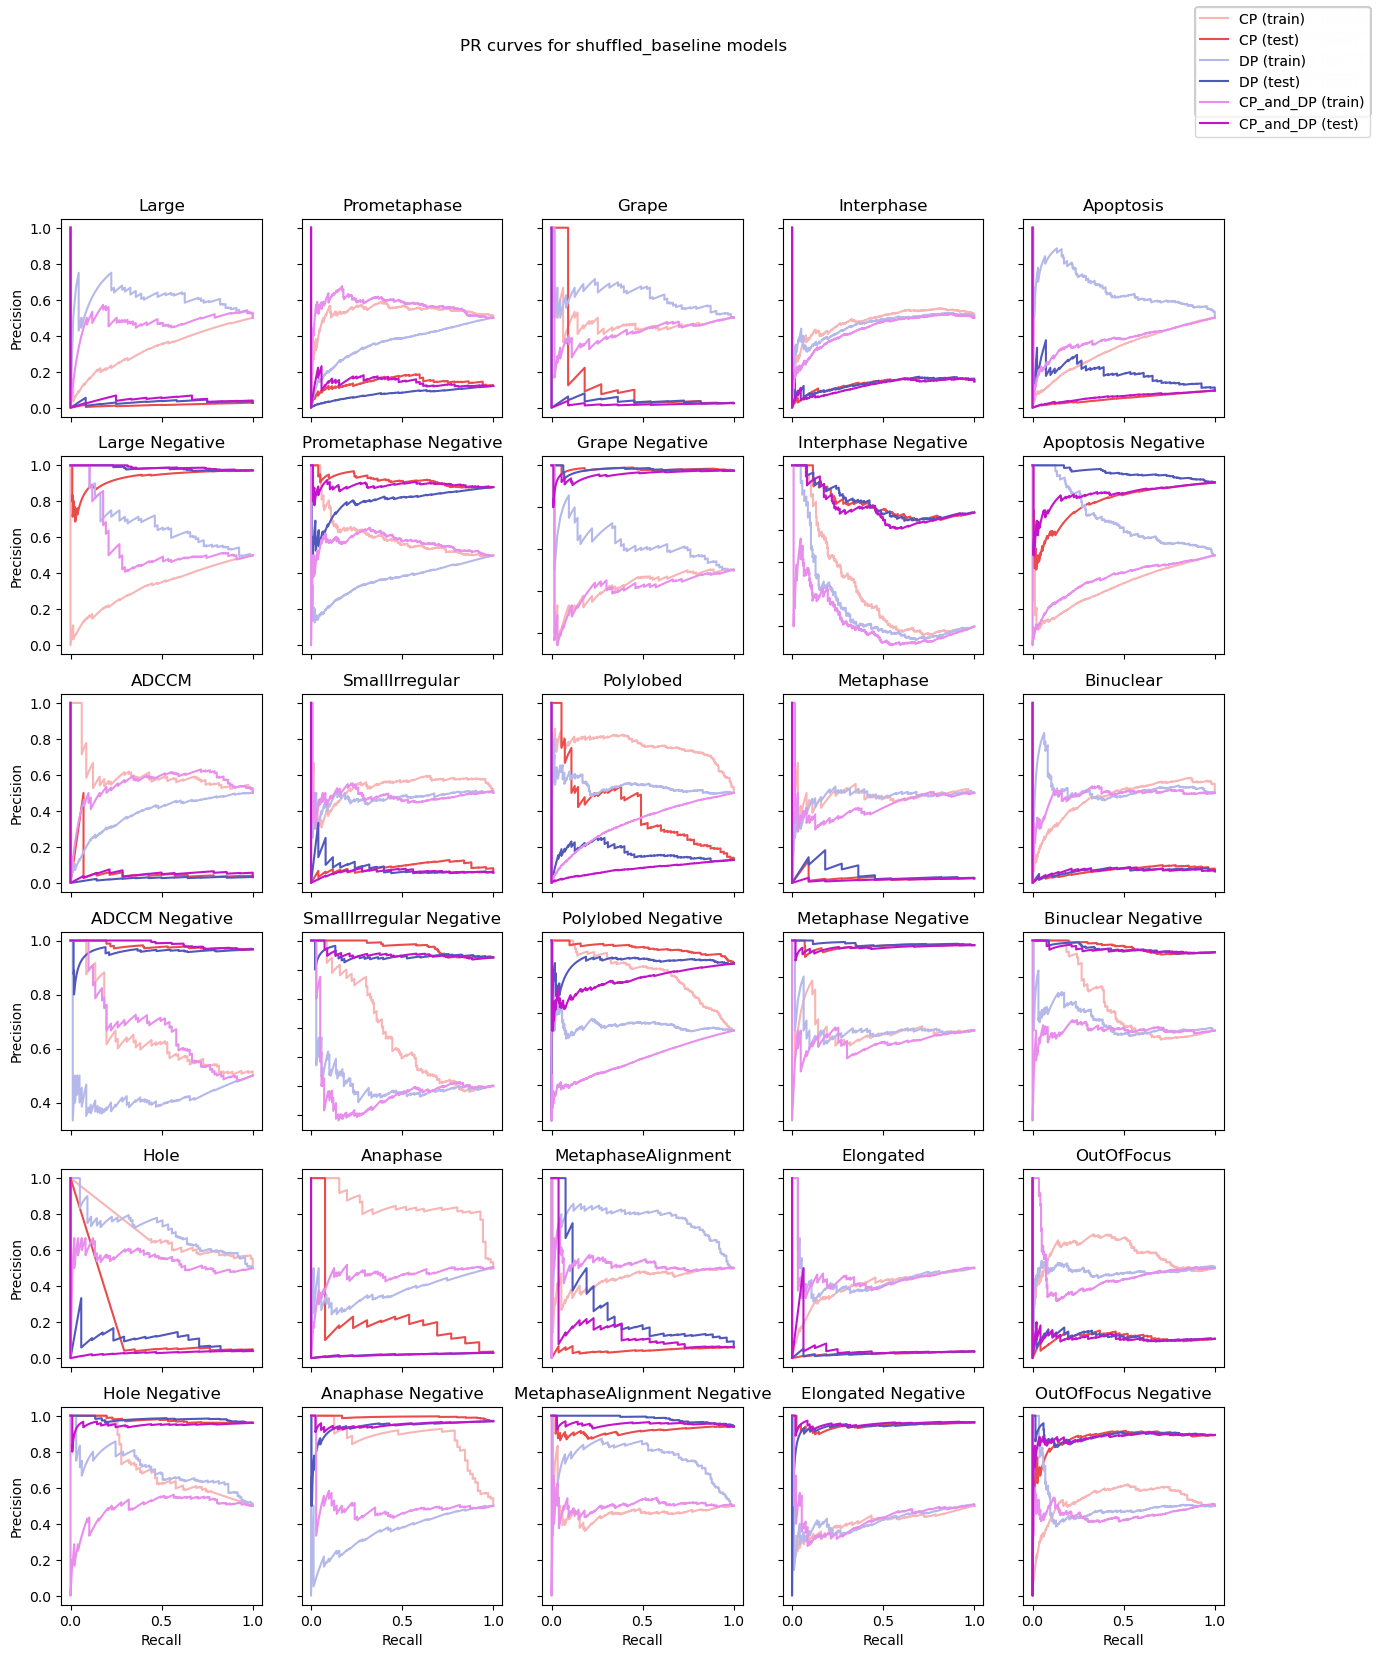

In [5]:
# directory to load the models from
single_class_models_dir = pathlib.Path("../2.train_model/models/single_class_models")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_class_PR_curves = []

# define combinations to test over
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP", "DP", "CP_and_DP"]
evaluation_types = ["train", "test"]
phenotypic_classes = features_dataframe["Mitocheck_Phenotypic_Class"].unique()

# colors for plotted lines
data_split_colors = {
    "CP_and_DP (test)": "#C214CB",
    "CP_and_DP (train)": "#E88EED",
    "CP (test)": "#EB4B4B",
    "CP (train)": "#F8B5B5",
    "DP (test)": "#5158bb",
    "DP (train)": "#B5B9EA",
}

# data from PR curves will be stored in tidy data format (eventually pandas dataframe)
compiled_SCM_PR_data = []

# iterate over each model type
# this is not included in itertools product because the PR curves figure needs to be generated for each model type with plt.show()
for model_type in model_types:
    # create a figure that has 6x5 subplots
    fig, axs = plt.subplots(6, 5)
    fig.set_size_inches(15, 18)

    # iterate through each combination of feature_types, evaluation_types, phenotypic_classes
    for feature_type, evaluation_type, phenotypic_class in itertools.product(
        feature_types, evaluation_types, phenotypic_classes
    ):

        # load single class model for this combination of model type, feature type, and phenotypic class
        single_class_model_path = pathlib.Path(
            f"{single_class_models_dir}/{phenotypic_class}_models/{model_type}__{feature_type}.joblib"
        )
        single_class_model = load(single_class_model_path)

        # load single cell data that will be used for evaluation
        single_cell_data = get_dataset(
            features_dataframe, data_split_indexes, evaluation_type
        )

        # index of phenotypic_class gives us an idea of where it should be plotted
        phenotypic_class_index = phenotypic_classes.tolist().index(phenotypic_class)

        # plot PR curves for single class models of this model type
        # this function also returns the PR curve data for this model type
        PR_data = class_PR_curves_SCM(
            single_cell_data,
            single_class_model,
            fig,
            axs,
            phenotypic_class_index,
            data_split_colors,
            model_type,
            feature_type,
            evaluation_type,
            phenotypic_class,
        )
        compiled_SCM_PR_data.append(PR_data)

    # add title to figure with all subplots
    fig.suptitle(f"PR curves for {model_type} models")
    plt.show()

### Save PR curves from each evaluation (multiclass)


In [6]:
# compile tidy PR data
# some thresholds are None because last PR value doesn't correspond to cell dataset (these values are always P=1, R=0), remove these rows from PR data
compiled_SCM_PR_data = (
    pd.concat(compiled_SCM_PR_data, axis=0).dropna().reset_index(drop=True)
)

# specify results directory
PR_curves_dir = pathlib.Path("evaluations/precision_recall_curves/")
PR_curves_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_PR_data_save_path = pathlib.Path(f"{PR_curves_dir}/compiled_SCM_PR_curves.tsv")

# save data as tsv
compiled_SCM_PR_data.to_csv(compiled_PR_data_save_path, sep="\t")

# preview tidy data
compiled_SCM_PR_data

,Model_Class,PR_Threshold,Precision,Recall,data_split,shuffled,feature_type
0,Large,0.022742,0.500000,1.000000,train,False,CP
1,Large,0.030259,0.503759,1.000000,train,False,CP
2,Large,0.035568,0.507576,1.000000,train,False,CP
3,Large,0.04418,0.511450,1.000000,train,False,CP
4,Large,0.044325,0.515385,1.000000,train,False,CP
...,...,...,...,...,...,...,...
135405,OutOfFocus Negative,0.707415,0.800000,0.010417,test,True,CP_and_DP
135406,OutOfFocus Negative,0.711525,0.750000,0.007812,test,True,CP_and_DP
135407,OutOfFocus Negative,0.724482,0.666667,0.005208,test,True,CP_and_DP
135408,OutOfFocus Negative,0.724807,0.500000,0.002604,test,True,CP_and_DP
